In [31]:
#SEGMENTATIONPower

In [32]:
#Calculate Segments via Kernel Change Point Detection using Power Information

In [33]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
%matplotlib inline
from IPython.display import Audio
import ruptures as rpt
import pandas as pd

In [34]:
#name="../Output/journey/journey_"
#path = "../" +"Data/journey/Journey - Gameplay  Playthrough (No Commentary)-[AudioTrimmer.com].mp3"

name="../Output/mario/mario_"
path = "../" +"Data/mario/Super Mario 64 [Part 1꞉ Bob-omb Battlefield] (No Commentary)-[AudioTrimmer.com].mp3"

#name="../Output/silenthill/silenthill_"
#path = "../" +"Data/silenthill/Silent Hill  Full UHD 4K  Longplay Walkthrough Gameplay No Commentary - 01.mp3"


x, Fs = librosa.load(path)
    
if len(x.shape) != 1:
    x = 0.5+(x[:, 0]+x[:, 1])

Audio(x, rate=Fs)

length_in_seconds = x.shape[0]/Fs
print('Sample rate: Fs=%0.0f Hz' % (Fs))
print('Length: %1d:%02d minutes' % (length_in_seconds//60, np.remainder(length_in_seconds, 60)))

Sample rate: Fs=22050 Hz
Length: 2:00 minutes


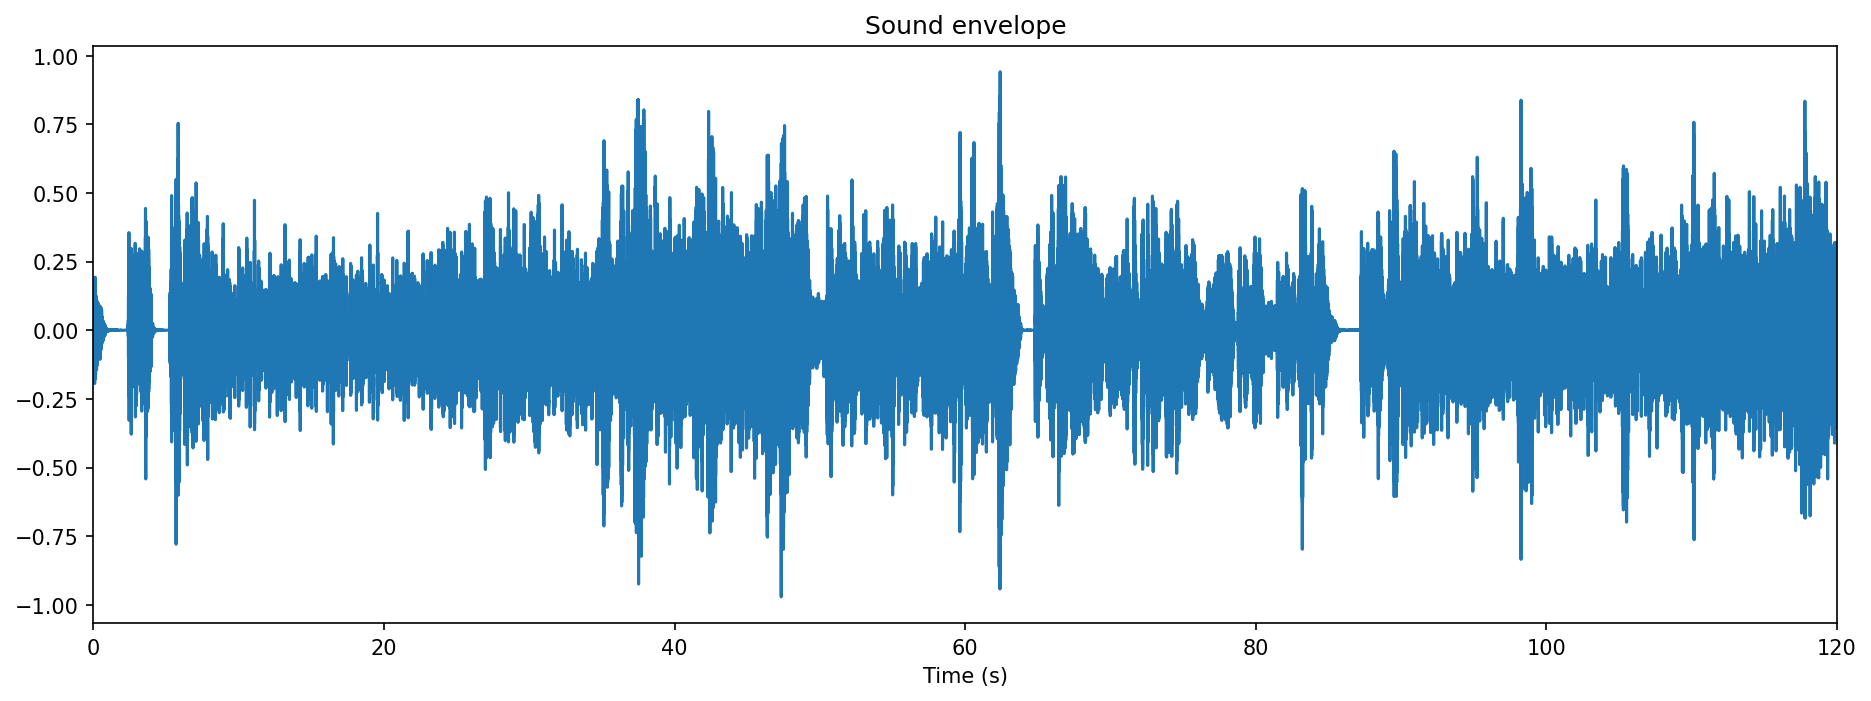

In [35]:

def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

# look at the envelope
fig, ax = fig_ax()
ax.plot(np.arange(x.size) / Fs, x)
ax.set_xlim(0, x.size / Fs)
ax.set_xlabel("Time (s)")
_ = ax.set(title="Sound envelope")

#save envelope
plt.savefig(name+"soundenvelope.png")



In [36]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

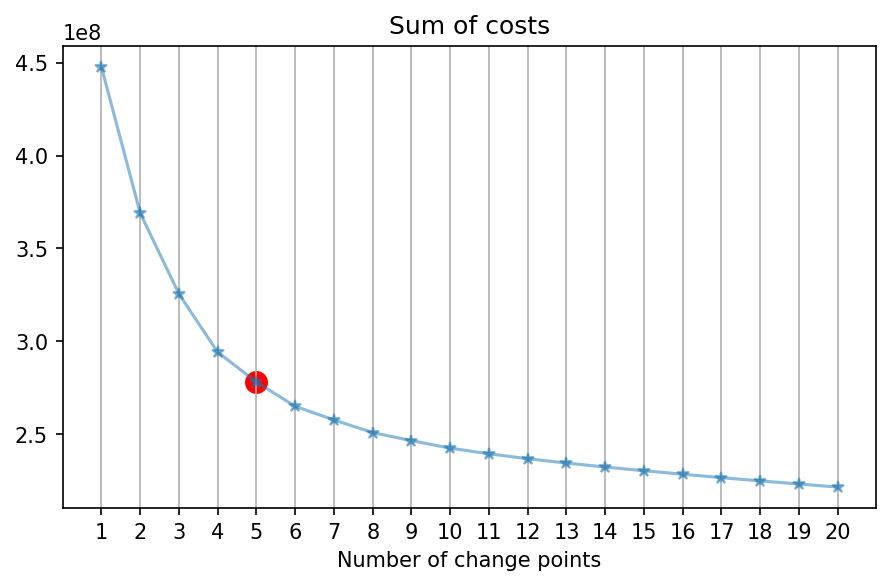

In [37]:

# Choose detection method
algo = rpt.KernelCPD(kernel="linear").fit(Xdb)

# Choose the number of changes (elbow heuristic)
n_bkps_max = 20  # K_max
# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
_ = algo.predict(n_bkps_max)

array_of_n_bkps = np.arange(1, n_bkps_max + 1)


def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)


fig, ax = fig_ax((7, 4))
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
ax.set_xticks(array_of_n_bkps)
ax.set_xlabel("Number of change points")
ax.set_title("Sum of costs")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max + 1)

# Visually we choose n_bkps=5 (highlighted in red on the elbow plot)
n_bkps = 5
_ = ax.scatter([5], [get_sum_of_cost(algo=algo, n_bkps=5)], color="r", s=100)

[0.00340136 0.01170068 0.02235828 0.03346939 0.04430839 0.04648526]
[75, 258, 493, 738, 977, 1025]


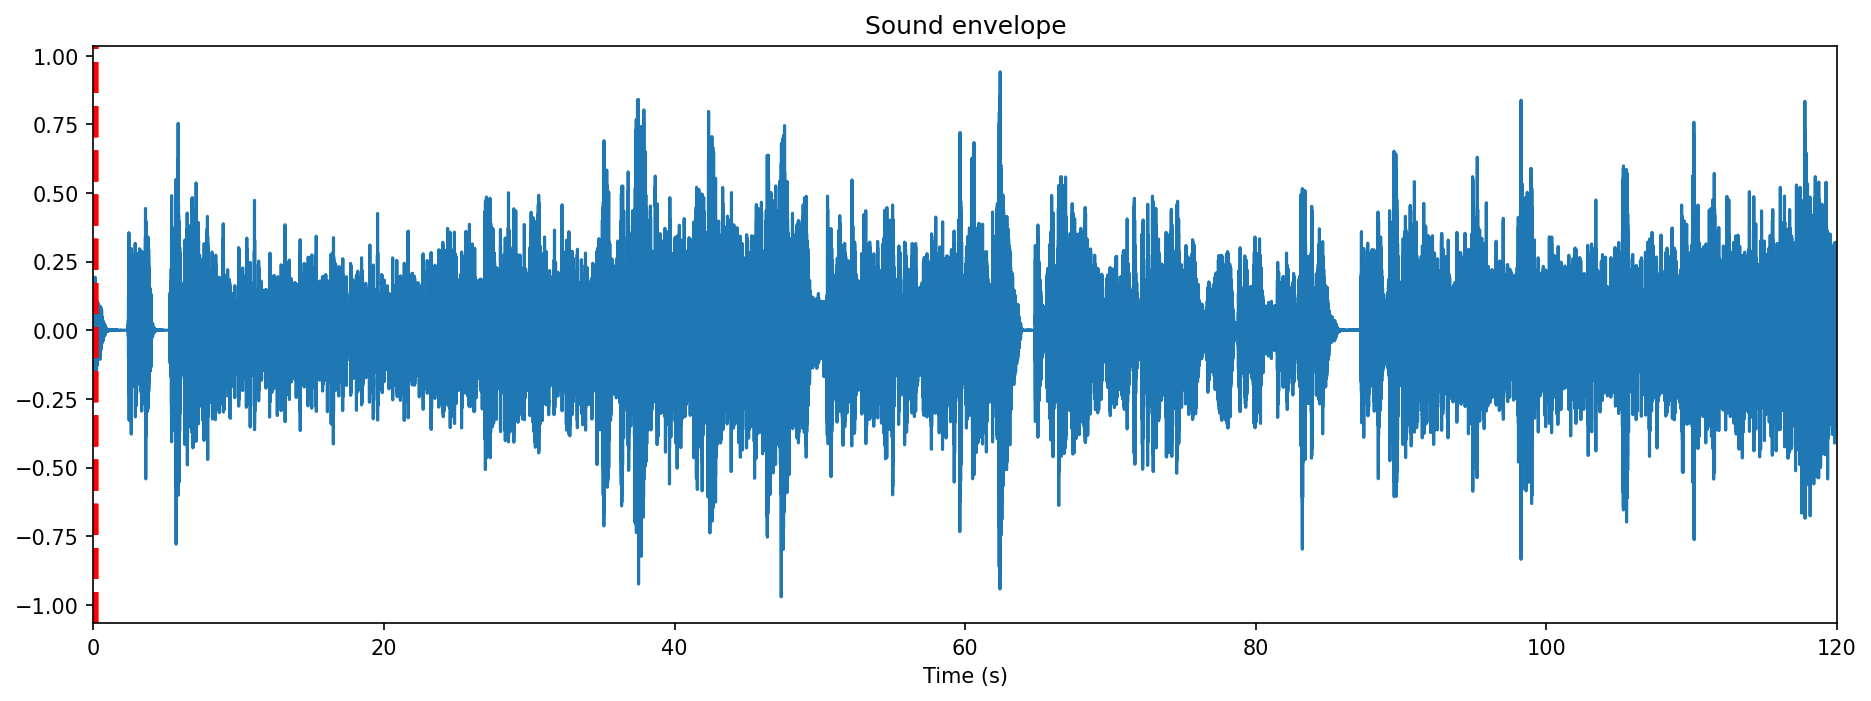

In [38]:
##Welche Größe hat hop_length hier????

# Segmentation
bkps = algo.predict(n_bkps=n_bkps)


hop_length_tempo= x.size / Fs
# Convert the estimated change points (frame counts) to actual timestamps
#bkps_times = librosa.frames_to_time(bkps, sr=Fs, hop_length=hop_length_tempo)
bkps_times = librosa.samples_to_time(bkps, sr=Fs)


print(bkps_times)
print(bkps)
# look at the envelope
fig, ax = fig_ax()
ax.plot(np.arange(x.size) / Fs, x)
ax.set_xlim(0, x.size / Fs)
ax.set_xlabel("Time (s)")
_ = ax.set(title="Sound envelope")

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="red", lw=4)
    
#plt.savefig(name+"Segment_soundenvelope.png")

In [39]:
# Compute change points corresponding indexes in original signal
bkps_time_indexes = (Fs * bkps_times).astype(int).tolist()

for segment_number, (start, end) in enumerate(
    rpt.utils.pairwise([0] + bkps_time_indexes), start=1
):
    segment = x[start:end]
    print(f"Segment n°{segment_number} (duration: {segment.size/Fs:.2f} s)")
    display(Audio(data=segment, rate=Fs))

Segment n°1 (duration: 0.00 s)


Segment n°2 (duration: 0.01 s)


Segment n°3 (duration: 0.01 s)


Segment n°4 (duration: 0.01 s)


Segment n°5 (duration: 0.01 s)


Segment n°6 (duration: 0.00 s)


In [40]:
# Convert seconds to "HH:MM:SS:MS"-format
def convert_to_time_format(seconds):
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    milliseconds = int((seconds - int(seconds)) * 100)
    return "{:02}:{:02}:{:02}:{:02}".format(int(hours), int(minutes), int(seconds), milliseconds)

# Convert "HH:MM:SS:MS"-format to seconds
def convert_to_seconds(timestring):
    hours, minutes, seconds, milliseconds = map(int, timestring.split(':'))
    return hours * 3600 + minutes * 60 + seconds + milliseconds / 100


# Save data as DataFrame
df = pd.DataFrame(bkps_times, columns=["end_ts"])

# Add new columns
df = df.assign(segment_id=np.arange(1, len(df) + 1),
               segmentation_name="audio-Power-segmentation")

# Rename the "start_ts" column to "end_ts" and apply conversion function
df["end_ts"] = df["end_ts"].apply(convert_to_time_format)

# Create the "start_ts" column
df["start_ts"] = df["end_ts"].shift(fill_value=convert_to_time_format(0))

# Create the "duration_ts" column
df["duration_ts"] = (df["end_ts"].apply(convert_to_seconds) - df["start_ts"].apply(convert_to_seconds)).apply(convert_to_time_format)

# Rearrange columns
df = df[["segment_id", "segmentation_name", "start_ts", "end_ts", "duration_ts"]]

# Save DataFrame to a CSV file
df.to_csv(name + "bkps_timesPower.csv", index=True)